EKF implementation for a differential drive robot in a 2D plane. The system is modeled with 4 states and 2 inputs. The states are x position, y position, heading angle and velocity. The inputs are angular rate, and linear acceleration along x. 

In [24]:
from math import sin, cos, remainder
import numpy as np
    
class Vehicle:
    def __init__(self, x=np.array([0,0,0,0]), u=np.array([0,0]), T=0.01, measurement_stds=np.array([0.1,0.1,0.0001,0.0002])):
        # x: x, y, theta, v
        # u: a, omega
        self.T = T
        self.measurement_stds = measurement_stds

        self.x = x
        self.u = u
        self.x_data = np.empty((0,4), float)
        self.u_data = np.empty((0,2), float)

    def f(self, x, u, enable_noise=True):
        #Zero-order hold discretization. x_dot ≈ 1/dt(x_k+1 - x_k)
        #Ad = I + A*dt, Bd = B*dt
        #x_dot = v*cos(theta)
        #y_dot = v*sin(theta)
        #theta_dot = omega
        #v_dot = a
        B = np.array([
            [0, 0],
            [0, 0],
            [0, 1],
            [1, 0]
        ])
        A = np.zeros((self.x.size, self.x.size))
        A[0,3] = cos(x[2])
        A[1,3] = sin(x[2])
        
        Ad = np.eye(self.x.size) + A*self.T
        Bd = B*self.T

        x_new = Ad @ x + Bd @ (u + enable_noise*np.random.normal(0, self.measurement_stds[-2:]))
        x_new[2] = remainder(x_new[2], 2*np.pi)  # Limit to -pi~pi
        return x_new

    def F(self, x):
        return np.array([
            [1, 0, -x[3]*self.T*sin(x[2]), self.T*cos(x[2])],
            [0, 1, x[3]*self.T*cos(x[2]), self.T*sin(x[2])],
            [0, 0, 1, 0],
            [0, 0, 0, 1]
        ])

    def g(self, x, enable_noise=True):
        Cd = np.array([
            [1, 0, 0, 0],
            [0, 1, 0, 0]
        ])
        return Cd @ x + enable_noise*np.random.normal(0, self.measurement_stds[:2]).T

    def G(self):
        return np.array([
            [1, 0, 0, 0],
            [0, 1, 0, 0]
        ])

Three different nosie levels for position, angular rate and linear acceleration measurements are compared. Initialize one of the corresponding measurements noise standard deviations below. 

In addition, a longer simulation time is performed for the last cell.

Resulting plots of the experiments are saved below for easier comparison.

In [37]:
# Low noise in position, angular rate and linear acceleration
# Short simulation

measurement_stds = np.array([0.3,0.3,0.05,0.1])
num_iterations = 10000

In [49]:
# High position noise, low angular rate and linear acceleration noise
# Short simulation

measurement_stds = np.array(([3.0,3.0,0.05,0.1]))
num_iterations = 10000

In [46]:
# Low position noise, high angular rate and linear acceleration noise
# Short simulation

measurement_stds = np.array(([0.3,0.3,0.1,0.2]))
num_iterations = 10000

In [17]:
# High position, angular rate and linear acceleration noise
# Long simulation

measurement_stds = np.array(([3.0,3.0,0.1,0.2]))
num_iterations = 50000

In [40]:
# Low noise in position, angular rate and linear acceleration
# Long simulation

measurement_stds = np.array([0.3,0.3,0.05,0.1])
num_iterations = 50000

In [50]:
from cgitb import enable
from time import time
from math import remainder
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(0)   #For repeatability

num_states = 4
num_measurements = 2

position_update_freq = 100
timesteps = np.arange(0,num_iterations)

trajectory = np.empty((0,num_states), float)
ground_truth = np.empty((0,num_states), float)
NIS = np.empty((0,1), float)
NEES = np.empty((0,1), float)

#Initialize model
x0 = np.array([0,0,0,0])
P0 = 1e-4*np.eye(num_states)
gt = x0

vehicle = Vehicle(x=x0, measurement_stds=measurement_stds)

u = np.vstack((num_iterations*[0.1], num_iterations*[0.5]))
u[0, num_iterations//4:3*num_iterations//4] = 0 # Drive in a circle for 3/5 the simulation

x_prev = x0
P_prev = P0

Q = np.diag(np.concatenate((np.array([2e-2,2e-2]), measurement_stds[-2:])))**2
Q = np.diag([1e-1,1e-1,1e-2,2e-2])**2
Q = np.diag([1e-1,1e-1,1e-2,5e-2])**2
R = np.diag(measurement_stds[:2])**2

G = vehicle.G()

k = 0
while k <= num_iterations - 1:
    
    #Prediction step
    P_pred = vehicle.F(x_prev) @ P_prev @ vehicle.F(x_prev).T + Q
    x_pred = vehicle.f(x_prev, u[:,k], enable_noise=True)
    
    #Kalman gain and covariance
    S = G @ P_pred @ G.T + R    # Innovation covariance
    K = np.linalg.solve(S.T, (P_pred @ G.T).T).T   #Faster than P_pred @ G.T @ np.linalg.inv(G @ P_pred @ G.T + R)
    P = (np.eye(num_states) - K @ G) @ P_pred
    P_prev = P
    
    gt = vehicle.f(gt, u[:,k], enable_noise=False)
    if (k % position_update_freq == 0):
        #Update step
        y = vehicle.g(gt, enable_noise=True)
        g = vehicle.g(x_pred, enable_noise=False)
        innovation = y - g
        x = x_pred + K @ innovation
        x_prev = x

        NIS = np.vstack((NIS, innovation.T @ np.linalg.solve(S, innovation)))
    else:
        x = x_pred
        x_prev = x

    #Store estimated trajectory
    trajectory = np.vstack((trajectory, x))

    #Store ground truth
    ground_truth = np.vstack((ground_truth, gt))
    estimation_error = gt - x
    estimation_error[2] = remainder(estimation_error[2], 2*np.pi) # Limit to -pi~pi

    NEES = np.vstack((NEES, estimation_error.T @ np.linalg.solve(P, estimation_error)))

    #Count iterations
    k+=1
    
ANIS = np.mean(NIS)
ANEES = np.mean(NEES)

With higher noise in position measurements, the EKF estimates of position starts diverging with increased rate. 
Higher noise in angular rate and linear acceleration measurement produces similar results, however it is possible to observe that the esitmates are better corrected towards the ground truth position, while the angle seems to have a higher error before the correction.  

In the configuration we have used, the angular rate and linear acceleration measurement noise appears in Q because they are modeled as inputs to the system, while the position measurement noise appears in R. The R matrix is calculated from the standard deviation of the known noise in our position estimate. This is often the case in practice. Usually, the R matrix can be determined directly from the measured noise covariance, while Q often needs tuning. In this experiment, the input noise is known and the Q matrix is a result of tuning by hand. To see the effects of the Q matrix, the tune for low noise were used for all experiments. Looking at the plots for normalized innovation squared (NIS) and normalized estimation error squared (NEES), the filter become overconfident in the higher noise experiments. This is due to the low covariances in the tuned Q matrix relative to the actual process noise.

The tuning was done iteratively by looking at values for NIS and NEES and their confidence bounds. The NIS is chi-square distributed with an expected value equal to the number of measurements. The NEES follows a similar distribution, with expected value equal to the number of states. By calculating bounds for a confidence interval for these distributions and comparing them to the NIS/NEES, we determine the filter consistency. If the NIS/NEES falls within the bounds at a given timestep *k*, we can be 95% certain that the filter is consistent at *k*. If the NIS/NEES is *below* the lower bound, the filter is *underconfident*. If it is *above*, it is *overconfident*. We can use this fact to determine whether the elements of Q (and R) matrix should be decreased or increased. In practice, one is often limited to analyzing the NIS only because the NEES calculation depends on an available ground truth. In this experiment, we could imagine an approximate ground truth being available through RTK GNSS or motion capture systems.


ANIS: 2.00
ANEES: 4.40
[3.   3.   0.05 0.1 ]
NIS within 95.00 percentile: 89.00%
NEES within 95.00 percentile: 81.62%


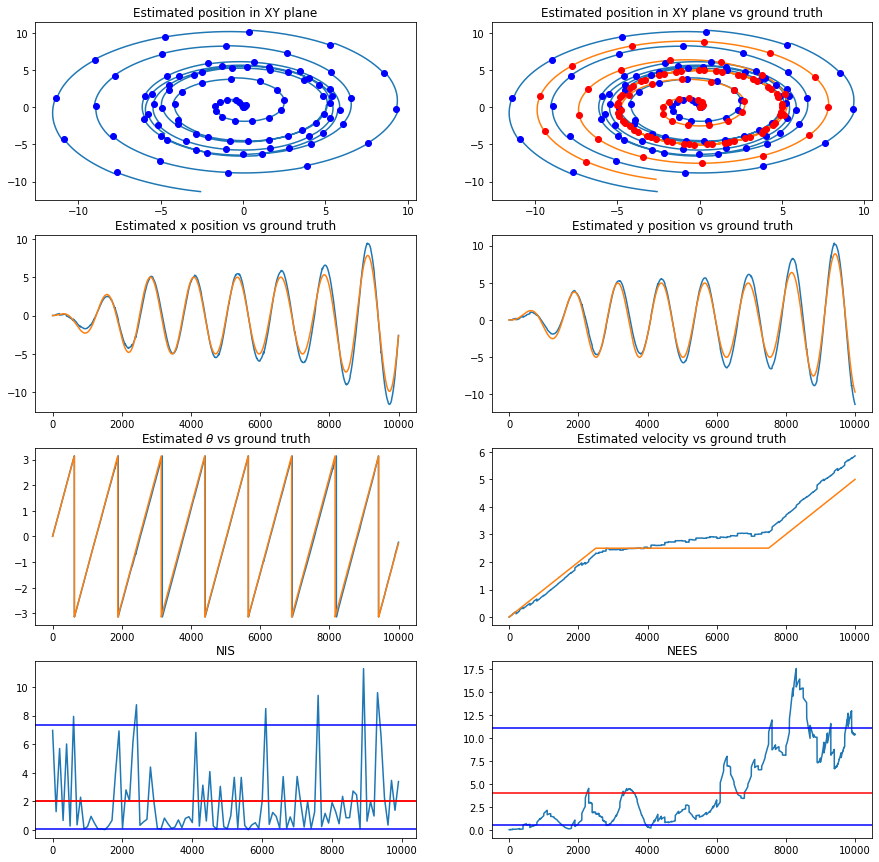

In [51]:
from scipy.stats.distributions import chi2

# Using https://arxiv.org/abs/1807.08855 for tuning
print(f"ANIS: {ANIS:.2f}")
print(f"ANEES: {ANEES:.2f}")

print(measurement_stds)

confidence = 0.95
alpha = 1 - confidence
NEES_bounds = [chi2.ppf(alpha/2, df=num_states), chi2.ppf(1-alpha/2, df=num_states)]
NIS_bounds = [chi2.ppf(alpha/2, df=num_measurements), chi2.ppf(1-alpha/2, df=num_measurements)]

NIS_within_bounds = ((NIS_bounds[0] < NIS) & (NIS < NIS_bounds[1])).sum()/NIS.size
NEES_within_bounds = ((NEES_bounds[0] < NEES) & (NEES < NEES_bounds[1])).sum()/NEES.size

print(f"NIS within {confidence*100:.2f} percentile: {NIS_within_bounds*100:.2f}%")
print(f"NEES within {confidence*100:.2f} percentile: {NEES_within_bounds*100:.2f}%")

#Plotting
plt.rcParams['figure.figsize'] = [15, 15]
fig, axs = plt.subplots(4, 2)
axs[0,0].plot(trajectory[:,0], trajectory[:,1])
axs[0,0].plot(trajectory[::position_update_freq,0], trajectory[::position_update_freq,1], 'bo')
axs[0,0].set_title('Estimated position in XY plane')
axs[0,1].plot(trajectory[:,0], trajectory[:,1], ground_truth[:,0], ground_truth[:,1])
axs[0,1].plot(trajectory[::position_update_freq,0], trajectory[::position_update_freq,1], 'bo')
axs[0,1].plot(ground_truth[::position_update_freq,0], ground_truth[::position_update_freq,1], 'ro')
axs[0,1].set_title('Estimated position in XY plane vs ground truth')
states = ["x position","y position",r"$\theta$","velocity"]
for i in range(num_states):
    axs[1+i//2, i%2].plot(timesteps, trajectory[:,i], ground_truth[:,i])
    axs[1+i//2, i%2].set_title(f'Estimated {states[i]} vs ground truth')
axs[3,0].plot(timesteps[::position_update_freq], NIS[:,0])
axs[3,0].axhline(y = num_measurements, color = 'r', linestyle = '-')
axs[3,0].set_title('NIS')
axs[3,0].axhline(y = num_measurements, color = 'r', linestyle = '-')
[axs[3,0].axhline(y = i, color = 'b', linestyle = '-') for i in NIS_bounds]
axs[3,1].plot(timesteps, NEES[:,0])
axs[3,1].set_title('NEES')
axs[3,1].axhline(y = num_states, color = 'r', linestyle = '-')
[axs[3,1].axhline(y = i, color = 'b', linestyle = '-') for i in NEES_bounds]
pass